In [91]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from pathlib import Path
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score
import sys
from scipy.spatial.distance import directed_hausdorff

# Dodaj src do path (working dir to już katalog główny projektu)
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
sys.path.insert(0, str(project_root / 'src'))

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 8)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Używane urządzenie: {device}")
print(f"Working dir: {Path.cwd()}")

Używane urządzenie: cuda
Working dir: /home/pswiebocki/projects/LiverTumorSegmentation


## 1. Załaduj model

In [92]:
from unet import UNet

# Ścieżka do wytrenowanego modelu
model_path = project_root / 'src' / 'best_model.pth'

# Inicjalizacja modelu
model = UNet(in_channels=1, num_classes=3)
model = model.to(device)

# Załaduj wagi
if model_path.exists():
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint)
    print(f"✓ Załadowano model z: {model_path}")
    model.eval()
else:
    print(f"⚠️ Nie znaleziono modelu: {model_path}")
    print(f"Dostępne modele: {list((project_root / 'src').glob('*.pth'))}")

# Podsumowanie modelu
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n📊 Parametry modelu:")
print(f"  Wszystkie: {total_params:,}")
print(f"  Trenowalne: {trainable_params:,}")

/tmp/ipykernel_1193357/186962951.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


✓ Załadowano model z: /home/pswiebocki/projects/LiverTumorSegmentation/src/best_model.pth

📊 Parametry modelu:
  Wszystkie: 31,042,499
  Trenowalne: 31,042,499


## 2. Przygotuj zbiór testowy

In [93]:
from Dataset import Dataset
from torch.utils.data import DataLoader, Subset
from img_transformations import get_train_transform

# 1. Załaduj informacje o splitcie z treningu
split_path = project_root / 'src' / 'train_test_split.json'

with open(split_path, 'r') as f:
    split_info = json.load(f)

print("📂 Informacje o splitcie:")
print(f"  Train samples: {split_info['train_size']}")
print(f"  Test samples: {split_info['test_size']}")
print(f"  Total: {split_info['total_size']}")
print(f"  Pacjenci użyci w treningu: {split_info['limit_patients']}")

# 2. Stwórz DOKŁADNIE ten sam dataset co w train.py
test_dataset = Dataset(
    base_dir=str(project_root / 'data' / 'prepared'),
    transformation=get_train_transform(),
    limit_patients=split_info['limit_patients']
)

print(f"\n✓ Dataset utworzony: {len(test_dataset)} total slice'ów")

# 3. Użyj zapisanych indeksów testowych
test_indices = split_info['test_indices']
test_set = Subset(test_dataset, test_indices)

print(f"✓ Test set: {len(test_set)} slice'ów (z zapisanego splitu)")

# 4. DataLoader
test_loader = DataLoader(
    test_set, 
    batch_size=8, 
    shuffle=False,
    num_workers=2
)

print(f"\n🎯 GOTOWE! Używamy dokładnie tych samych {len(test_set)} slice'ów testowych co w train.py")

📂 Informacje o splitcie:
  Train samples: 4369
  Test samples: 1093
  Total: 5462
  Pacjenci użyci w treningu: 50


/home/pswiebocki/miniconda3/envs/liverseg/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Pominięto uszkodzony plik CT: /home/pswiebocki/projects/LiverTumorSegmentation/data/prepared/person_30/liver/ct/slice_112.npy, błąd: No data left in file
Pominięto uszkodzony plik CT: /home/pswiebocki/projects/LiverTumorSegmentation/data/prepared/person_30/liver/ct/slice_113.npy, błąd: No data left in file
Pominięto uszkodzony plik CT: /home/pswiebocki/projects/LiverTumorSegmentation/data/prepared/person_30/liver/ct/slice_114.npy, błąd: No data left in file
Pominięto uszkodzony plik CT: /home/pswiebocki/projects/LiverTumorSegmentation/data/prepared/person_30/liver/ct/slice_115.npy, błąd: No data left in file
Pominięto uszkodzony plik CT: /home/pswiebocki/projects/LiverTumorSegmentation/data/prepared/person_30/liver/ct/slice_116.npy, błąd: No data left in file
Pominięto uszkodzony plik CT: /home/pswiebocki/projects/LiverTumorSegmentation/data/prepared/person_30/liver/ct/slice_117.npy, błąd: No data left in file
Pominięto uszkodzony plik CT: /home/pswiebocki/projects/LiverTumorSegmentati

## 3. Funkcje metryk

In [94]:
def dice_coefficient(pred, target, smooth=1e-6):
    """Oblicz Dice coefficient dla danej klasy"""
    pred_flat = pred.flatten()
    target_flat = target.flatten()
    
    intersection = (pred_flat * target_flat).sum()
    return (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)

def iou_score(pred, target, smooth=1e-6):
    """Oblicz IoU (Intersection over Union)"""
    pred_flat = pred.flatten()
    target_flat = target.flatten()
    
    intersection = (pred_flat * target_flat).sum()
    union = pred_flat.sum() + target_flat.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def pixel_accuracy(pred, target):
    """Oblicz pixel accuracy"""
    correct = (pred == target).sum()
    total = pred.numel()
    return correct / total

def precision_recall_f1(pred, target, class_id):
    """Oblicz precision, recall i F1 dla danej klasy"""
    pred_binary = (pred == class_id).astype(int).flatten()
    target_binary = (target == class_id).astype(int).flatten()
    
    if target_binary.sum() == 0:
        return 0.0, 0.0, 0.0
    
    precision = precision_score(target_binary, pred_binary, zero_division=0)
    recall = recall_score(target_binary, pred_binary, zero_division=0)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
    
    return precision, recall, f1

def hausdorff_distance(pred, target):
    """Oblicz Hausdorff distance (dla konturów)"""
    # Znajdź punkty konturu
    pred_points = np.argwhere(pred > 0)
    target_points = np.argwhere(target > 0)
    
    if len(pred_points) == 0 or len(target_points) == 0:
        return float('inf')
    
    # Directed Hausdorff distance w obie strony
    hd_forward = directed_hausdorff(pred_points, target_points)[0]
    hd_backward = directed_hausdorff(target_points, pred_points)[0]
    
    return max(hd_forward, hd_backward)

print("✓ Funkcje metryk zdefiniowane (Dice, IoU, Precision, Recall, F1, Hausdorff)")

✓ Funkcje metryk zdefiniowane (Dice, IoU, Precision, Recall, F1, Hausdorff)


## 4. Ewaluacja modelu na zbiorze testowym

In [95]:
# Struktury do zbierania metryk
metrics = {
    'dice': {'background': [], 'liver': [], 'tumor': []},
    'iou': {'background': [], 'liver': [], 'tumor': []},
    'precision': {'background': [], 'liver': [], 'tumor': []},
    'recall': {'background': [], 'liver': [], 'tumor': []},
    'f1': {'background': [], 'liver': [], 'tumor': []},
    'hausdorff': {'liver': [], 'tumor': []},
    'pixel_acc': []
}

# Zbierz predykcje i GT do confusion matrix
all_preds = []
all_targets = []

# Zbierz przykładowe predykcje do wizualizacji
sample_predictions = []

print("🔍 Rozpoczynam ewaluację modelu...\n")

model.eval()
with torch.no_grad():
    for batch_idx, (images, masks) in enumerate(test_loader):
        images = images.float().to(device)
        
        # Sprawdź wymiary i dostosuj
        if images.ndim == 4 and images.shape[-1] == 1:
            images = images.permute(0, 3, 1, 2)
        elif images.ndim == 3:
            images = images.unsqueeze(1)
            
        masks = masks.long().to(device)
        
        # Predykcja
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        
        # Konwertuj na numpy
        preds_np = preds.cpu().numpy()
        masks_np = masks.cpu().numpy()
        images_np = images.cpu().numpy()
        
        # Oblicz metryki dla każdego sample
        for i in range(preds_np.shape[0]):
            pred_i = preds_np[i]
            mask_i = masks_np[i]
            
            # Pixel accuracy
            acc = (pred_i == mask_i).mean()
            metrics['pixel_acc'].append(acc)
            
            # Metryki per klasa
            for class_id, class_name in enumerate(['background', 'liver', 'tumor']):
                pred_class = (pred_i == class_id).astype(np.float32)
                mask_class = (mask_i == class_id).astype(np.float32)
                
                if mask_class.sum() > 0:
                    # Dice i IoU
                    dice = dice_coefficient(torch.from_numpy(pred_class), torch.from_numpy(mask_class)).item()
                    iou = iou_score(torch.from_numpy(pred_class), torch.from_numpy(mask_class)).item()
                    metrics['dice'][class_name].append(dice)
                    metrics['iou'][class_name].append(iou)
                    
                    # Precision, Recall, F1
                    prec, rec, f1 = precision_recall_f1(pred_i, mask_i, class_id)
                    metrics['precision'][class_name].append(prec)
                    metrics['recall'][class_name].append(rec)
                    metrics['f1'][class_name].append(f1)
                    
                    # Hausdorff (tylko liver i tumor)
                    if class_name in ['liver', 'tumor'] and mask_class.sum() > 10:
                        try:
                            hd = hausdorff_distance(pred_class, mask_class)
                            if hd != float('inf'):
                                metrics['hausdorff'][class_name].append(hd)
                        except:
                            pass
            
            # Zbierz do confusion matrix
            all_preds.extend(pred_i.flatten())
            all_targets.extend(mask_i.flatten())
            
            # Zapisz przykłady do wizualizacji (pierwsze 10)
            # WAŻNE: zapisz indeks w datasecie aby później wczytać ORYGINALNE obrazy
            if len(sample_predictions) < 10:
                dataset_idx = batch_idx * test_loader.batch_size + i
                sample_predictions.append({
                    'dataset_idx': dataset_idx,  # Indeks w test_set
                    'image': images_np[i],  # Przetransformowany (do predykcji)
                    'mask': mask_i,
                    'pred': pred_i,
                    'dice_liver': dice_coefficient(
                        torch.from_numpy((pred_i == 1).astype(np.float32)),
                        torch.from_numpy((mask_i == 1).astype(np.float32))
                    ).item(),
                    'dice_tumor': dice_coefficient(
                        torch.from_numpy((pred_i == 2).astype(np.float32)),
                        torch.from_numpy((mask_i == 2).astype(np.float32))
                    ).item()
                })
        
        if (batch_idx + 1) % 10 == 0:
            print(f"Przetworzono {(batch_idx + 1) * test_loader.batch_size} / {len(test_set)} slice'ów")

print(f"📊 Zebrano metryki dla {len(metrics['pixel_acc'])} slice'ów")
print("\n✓ Ewaluacja zakończona!")

🔍 Rozpoczynam ewaluację modelu...

Przetworzono 80 / 1093 slice'ów
Przetworzono 160 / 1093 slice'ów
Przetworzono 240 / 1093 slice'ów
Przetworzono 320 / 1093 slice'ów
Przetworzono 400 / 1093 slice'ów
Przetworzono 480 / 1093 slice'ów
Przetworzono 560 / 1093 slice'ów
Przetworzono 640 / 1093 slice'ów
Przetworzono 720 / 1093 slice'ów
Przetworzono 800 / 1093 slice'ów
Przetworzono 880 / 1093 slice'ów
Przetworzono 960 / 1093 slice'ów
Przetworzono 1040 / 1093 slice'ów
📊 Zebrano metryki dla 1093 slice'ów

✓ Ewaluacja zakończona!


## 5. Wyniki - podsumowanie metryk

## 5.1. Diagnostyka - Rozkład klas w zbiorze testowym

In [96]:
# Sprawdź rozkład klas w Ground Truth
print("="*80)
print("🔍 DIAGNOSTYKA - ROZKŁAD KLAS W ZBIORZE TESTOWYM")
print("="*80)

# Policz piksele każdej klasy
class_counts = {0: 0, 1: 0, 2: 0}
slice_with_tumor = 0
slice_with_liver = 0

for target in all_targets:
    class_counts[target] += 1

for masks in [s['mask'] for s in sample_predictions]:
    if (masks == 2).any():
        slice_with_tumor += 1
    if (masks == 1).any():
        slice_with_liver += 1

total_pixels = sum(class_counts.values())

print(f"\n📊 Rozkład pikseli w Ground Truth:")
print(f"  Background (0): {class_counts[0]:,} pikseli ({class_counts[0]/total_pixels*100:.2f}%)")
print(f"  Liver (1):      {class_counts[1]:,} pikseli ({class_counts[1]/total_pixels*100:.2f}%)")
print(f"  Tumor (2):      {class_counts[2]:,} pikseli ({class_counts[2]/total_pixels*100:.2f}%)")

print(f"\n📸 Slice'y zawierające:")
print(f"  Liver: {slice_with_liver} / {len(sample_predictions)}")
print(f"  Tumor: {slice_with_tumor} / {len(sample_predictions)}")

# Sprawdź co model predykuje
pred_class_counts = {0: 0, 1: 0, 2: 0}
for pred in all_preds:
    pred_class_counts[pred] += 1

print(f"\n📊 Rozkład pikseli w Predykcjach modelu:")
print(f"  Background (0): {pred_class_counts[0]:,} pikseli ({pred_class_counts[0]/total_pixels*100:.2f}%)")
print(f"  Liver (1):      {pred_class_counts[1]:,} pikseli ({pred_class_counts[1]/total_pixels*100:.2f}%)")
print(f"  Tumor (2):      {pred_class_counts[2]:,} pikseli ({pred_class_counts[2]/total_pixels*100:.2f}%)")

if pred_class_counts[2] == 0:
    print("\n❌ PROBLEM: Model w ogóle nie predykuje klasy Tumor (2)!")
    print("   Możliwe przyczyny:")
    print("   1. Guzy są bardzo rzadkie w danych treningowych")
    print("   2. Model nauczył się je ignorować (class imbalance)")
    print("   3. Dice loss nie penalizuje wystarczająco za pominięcie rzadkich klas")
    print("\n💡 Rekomendacje:")
    print("   - Użyj weighted loss (większa waga dla tumor)")
    print("   - Focal loss dla trudnych przypadków")
    print("   - Zwiększ reprezentację guzów w augmentacji")
    print("   - Trenuj z focal loss lub class weights")

print("\n" + "="*80)

🔍 DIAGNOSTYKA - ROZKŁAD KLAS W ZBIORZE TESTOWYM

📊 Rozkład pikseli w Ground Truth:
  Background (0): 67,022,805 pikseli (93.57%)
  Liver (1):      4,416,204 pikseli (6.17%)
  Tumor (2):      191,839 pikseli (0.27%)

📸 Slice'y zawierające:
  Liver: 10 / 10
  Tumor: 2 / 10

📊 Rozkład pikseli w Predykcjach modelu:
  Background (0): 66,723,950 pikseli (93.15%)
  Liver (1):      4,714,792 pikseli (6.58%)
  Tumor (2):      192,106 pikseli (0.27%)



In [98]:
print("="*80)
print("📊 KOMPLEKSOWE WYNIKI EWALUACJI MODELU")
print("="*80)

print(f"\n🎯 PIXEL ACCURACY: {np.mean(metrics['pixel_acc'])*100:.2f}% ± {np.std(metrics['pixel_acc'])*100:.2f}%")

print("\n" + "="*80)
print("METRYKI PER KLASA")
print("="*80)

for class_name in ['background', 'liver', 'tumor']:
    if len(metrics['dice'][class_name]) > 0:
        print(f"\n📌 {class_name.upper()}")
        print(f"  {'Metryka':<15} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10}")
        print(f"  {'-'*55}")
        
        # Dice
        dice_vals = metrics['dice'][class_name]
        print(f"  {'Dice':<15} {np.mean(dice_vals):<10.4f} {np.std(dice_vals):<10.4f} {np.min(dice_vals):<10.4f} {np.max(dice_vals):<10.4f}")
        
        # IoU
        iou_vals = metrics['iou'][class_name]
        print(f"  {'IoU':<15} {np.mean(iou_vals):<10.4f} {np.std(iou_vals):<10.4f} {np.min(iou_vals):<10.4f} {np.max(iou_vals):<10.4f}")
        
        # Precision
        prec_vals = metrics['precision'][class_name]
        print(f"  {'Precision':<15} {np.mean(prec_vals):<10.4f} {np.std(prec_vals):<10.4f} {np.min(prec_vals):<10.4f} {np.max(prec_vals):<10.4f}")
        
        # Recall
        rec_vals = metrics['recall'][class_name]
        print(f"  {'Recall':<15} {np.mean(rec_vals):<10.4f} {np.std(rec_vals):<10.4f} {np.min(rec_vals):<10.4f} {np.max(rec_vals):<10.4f}")
        
        # F1
        f1_vals = metrics['f1'][class_name]
        print(f"  {'F1-Score':<15} {np.mean(f1_vals):<10.4f} {np.std(f1_vals):<10.4f} {np.min(f1_vals):<10.4f} {np.max(f1_vals):<10.4f}")
        
        # Hausdorff (tylko liver i tumor)
        if class_name in metrics['hausdorff'] and len(metrics['hausdorff'][class_name]) > 0:
            hd_vals = metrics['hausdorff'][class_name]
            print(f"  {'Hausdorff':<15} {np.mean(hd_vals):<10.2f} {np.std(hd_vals):<10.2f} {np.min(hd_vals):<10.2f} {np.max(hd_vals):<10.2f}")

# Średnie dla liver + tumor
print("\n" + "="*80)
print("⭐ ŚREDNIE DLA TKANEK (LIVER + TUMOR)")
print("="*80)

if len(metrics['dice']['liver']) > 0 and len(metrics['dice']['tumor']) > 0:
    mean_dice_tissues = np.mean(metrics['dice']['liver'] + metrics['dice']['tumor'])
    mean_iou_tissues = np.mean(metrics['iou']['liver'] + metrics['iou']['tumor'])
    mean_f1_tissues = np.mean(metrics['f1']['liver'] + metrics['f1']['tumor'])
    
    print(f"  Mean Dice:     {mean_dice_tissues:.4f}")
    print(f"  Mean IoU:      {mean_iou_tissues:.4f}")
    print(f"  Mean F1-Score: {mean_f1_tissues:.4f}")

print("\n" + "="*80)

📊 KOMPLEKSOWE WYNIKI EWALUACJI MODELU

🎯 PIXEL ACCURACY: 98.81% ± 1.40%

METRYKI PER KLASA

📌 BACKGROUND
  Metryka         Mean       Std        Min        Max       
  -------------------------------------------------------
  Dice            0.9937     0.0080     0.9266     1.0000    
  IoU             0.9875     0.0155     0.8632     1.0000    
  Precision       0.9961     0.0053     0.9301     1.0000    
  Recall          0.9914     0.0146     0.8749     1.0000    
  F1-Score        0.9937     0.0080     0.9266     1.0000    

📌 LIVER
  Metryka         Mean       Std        Min        Max       
  -------------------------------------------------------
  Dice            0.7911     0.2982     0.0000     0.9912    
  IoU             0.7272     0.2986     0.0000     0.9826    
  Precision       0.8021     0.2919     0.0000     1.0000    
  Recall          0.8106     0.3099     0.0000     1.0000    
  F1-Score        0.7911     0.2982     0.0000     0.9912    
  Hausdorff       42.69   

## 6. Wizualizacja rozkładu metryk

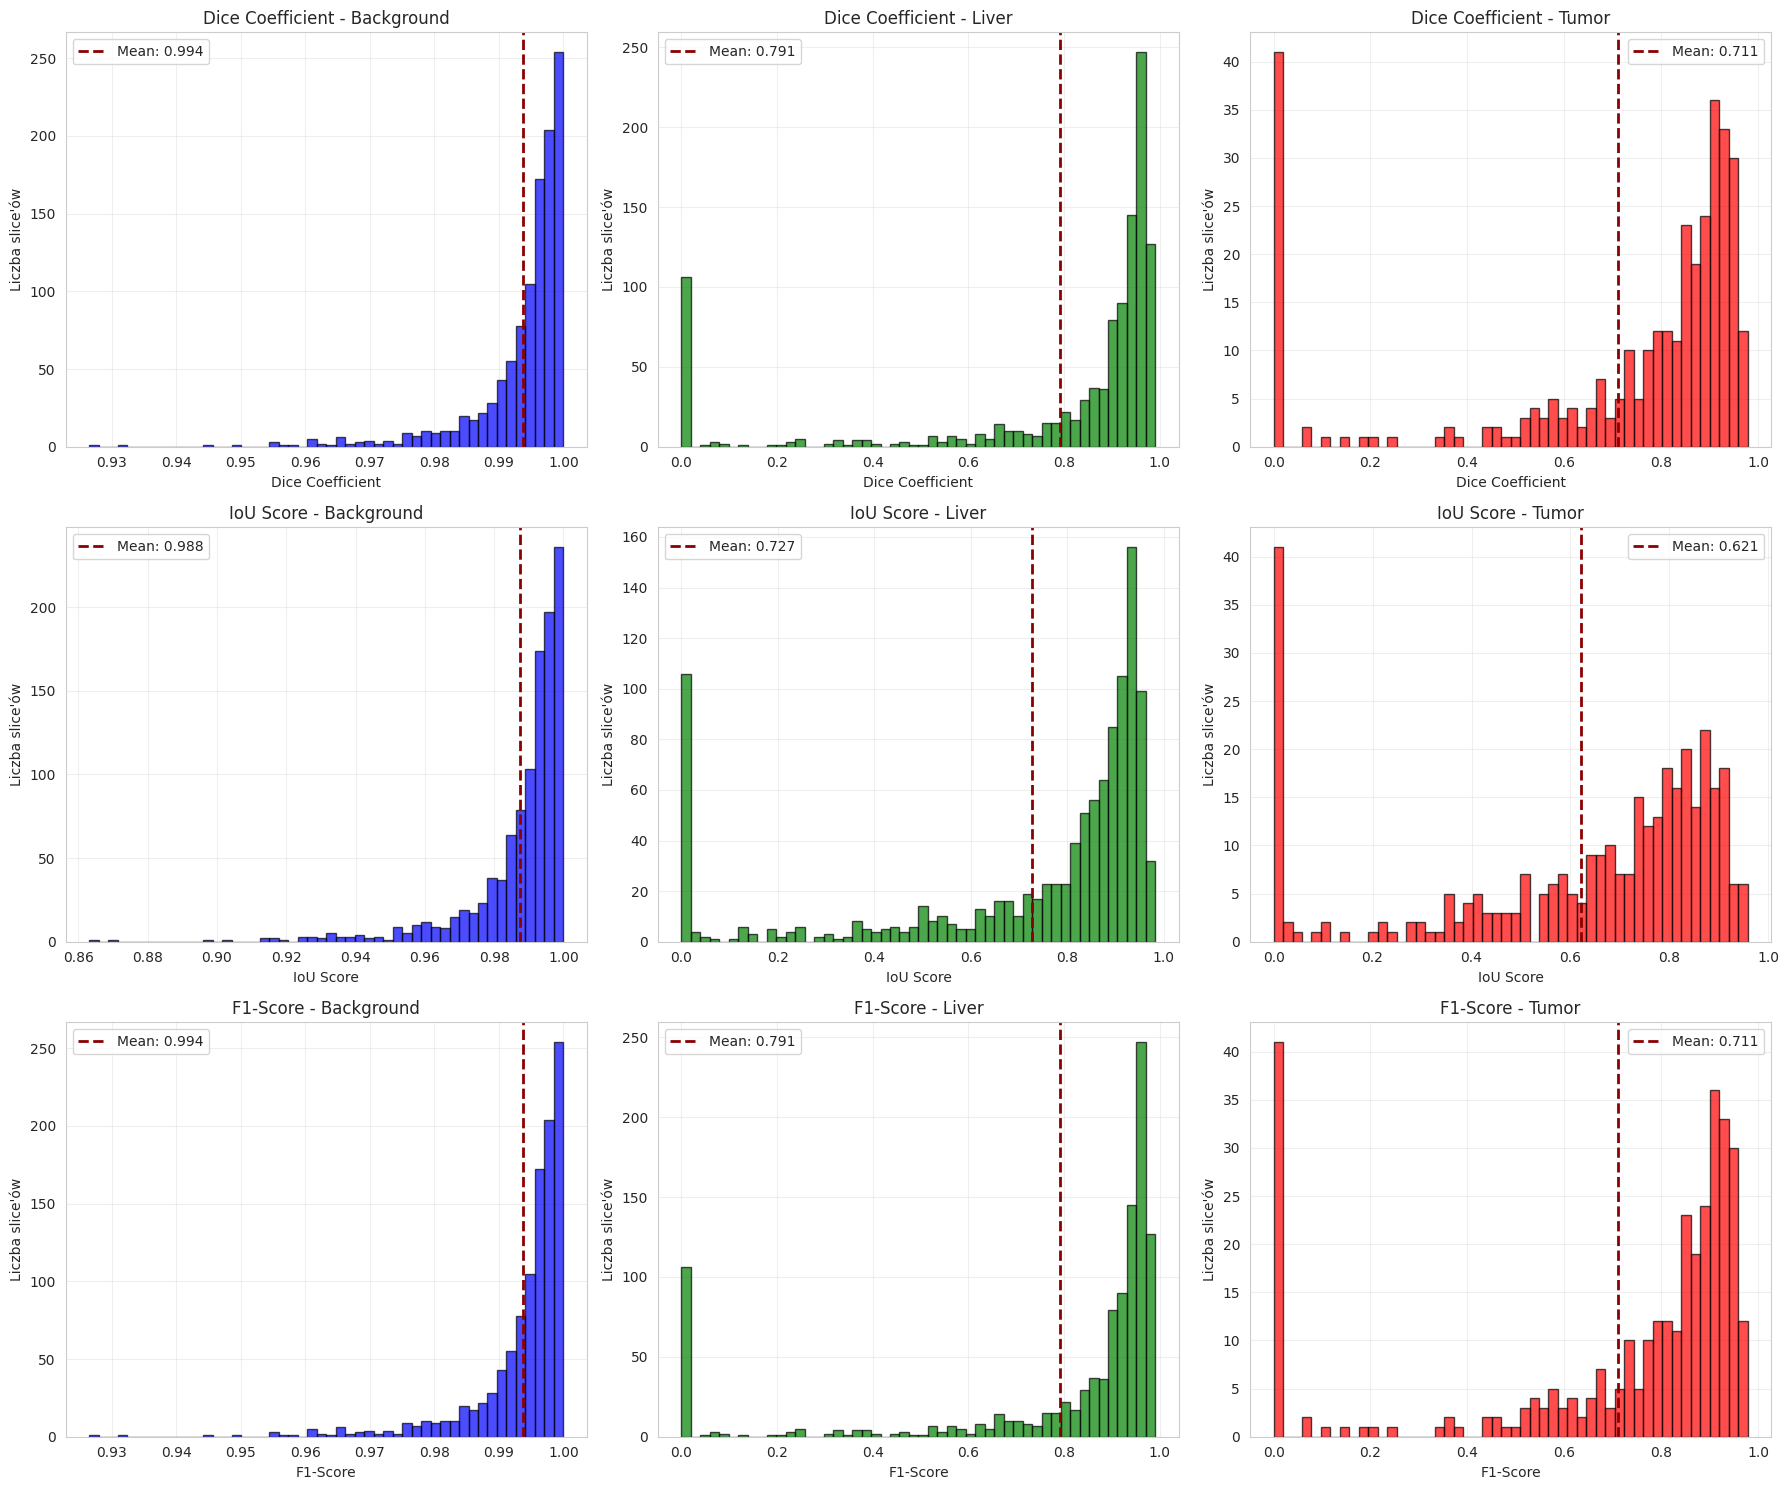

In [99]:
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

metrics_to_plot = [
    ('dice', 'Dice Coefficient'),
    ('iou', 'IoU Score'),
    ('f1', 'F1-Score')
]

for row, (metric_key, metric_name) in enumerate(metrics_to_plot):
    for col, class_name in enumerate(['background', 'liver', 'tumor']):
        if len(metrics[metric_key][class_name]) > 0:
            data = metrics[metric_key][class_name]
            axes[row, col].hist(data, bins=50, edgecolor='black', alpha=0.7, color=['blue', 'green', 'red'][col])
            axes[row, col].set_xlabel(metric_name)
            axes[row, col].set_ylabel('Liczba slice\'ów')
            axes[row, col].set_title(f'{metric_name} - {class_name.capitalize()}')
            axes[row, col].axvline(np.mean(data), color='darkred', 
                                linestyle='--', linewidth=2, label=f'Mean: {np.mean(data):.3f}')
            axes[row, col].legend()
            axes[row, col].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Confusion Matrix

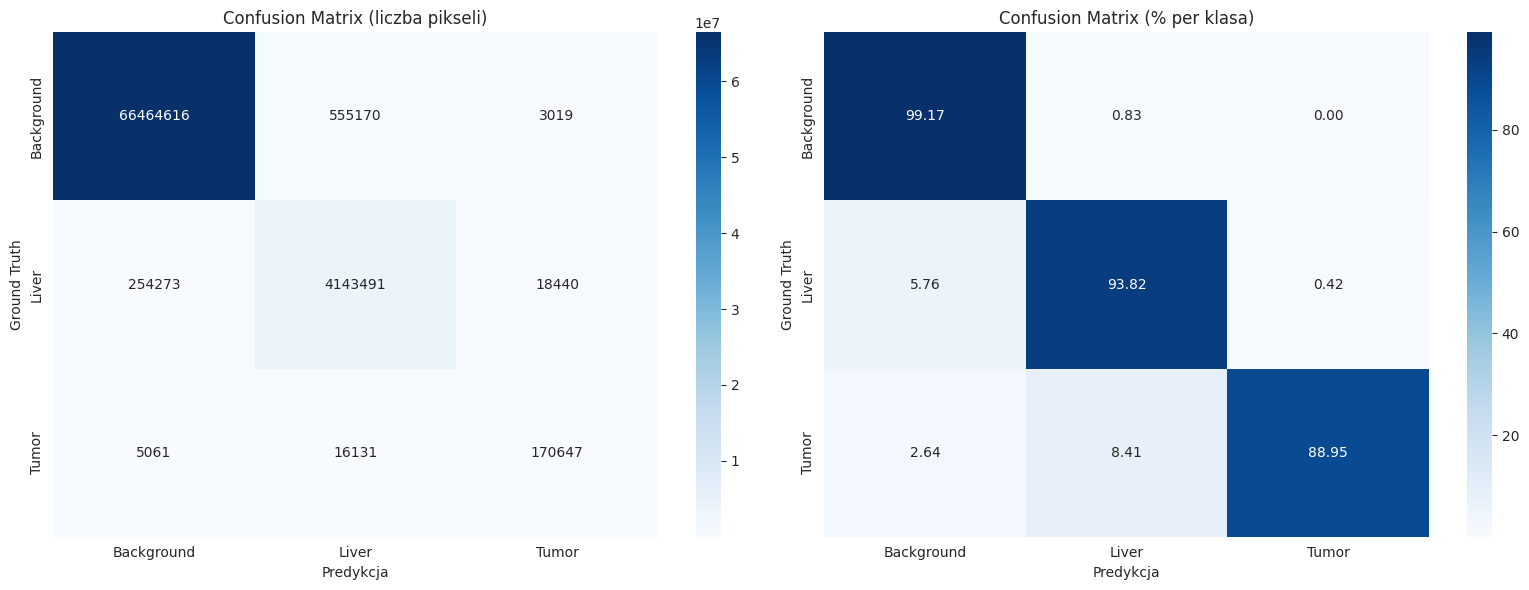


Classification Report:
              precision    recall  f1-score   support

  Background     0.9961    0.9917    0.9939  67022805
       Liver     0.8788    0.9382    0.9076   4416204
       Tumor     0.8883    0.8895    0.8889    191839

    accuracy                         0.9881  71630848
   macro avg     0.9211    0.9398    0.9301  71630848
weighted avg     0.9886    0.9881    0.9883  71630848



In [100]:
# Oblicz confusion matrix
cm = confusion_matrix(all_targets, all_preds, labels=[0, 1, 2])

# Normalizuj do procentów
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Wizualizacja
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Macierz surowa
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Background', 'Liver', 'Tumor'],
            yticklabels=['Background', 'Liver', 'Tumor'],
            ax=axes[0])
axes[0].set_xlabel('Predykcja')
axes[0].set_ylabel('Ground Truth')
axes[0].set_title('Confusion Matrix (liczba pikseli)')

# Macierz znormalizowana
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['Background', 'Liver', 'Tumor'],
            yticklabels=['Background', 'Liver', 'Tumor'],
            ax=axes[1])
axes[1].set_xlabel('Predykcja')
axes[1].set_ylabel('Ground Truth')
axes[1].set_title('Confusion Matrix (% per klasa)')

plt.tight_layout()
plt.show()

# Wypisz classification report
print("\nClassification Report:")
print(classification_report(all_targets, all_preds, 
                          target_names=['Background', 'Liver', 'Tumor'],
                          digits=4))

## 7.1. Wizualizacja z Error Maps

📸 Wizualizacja pierwszych 6 przykładów z error maps...



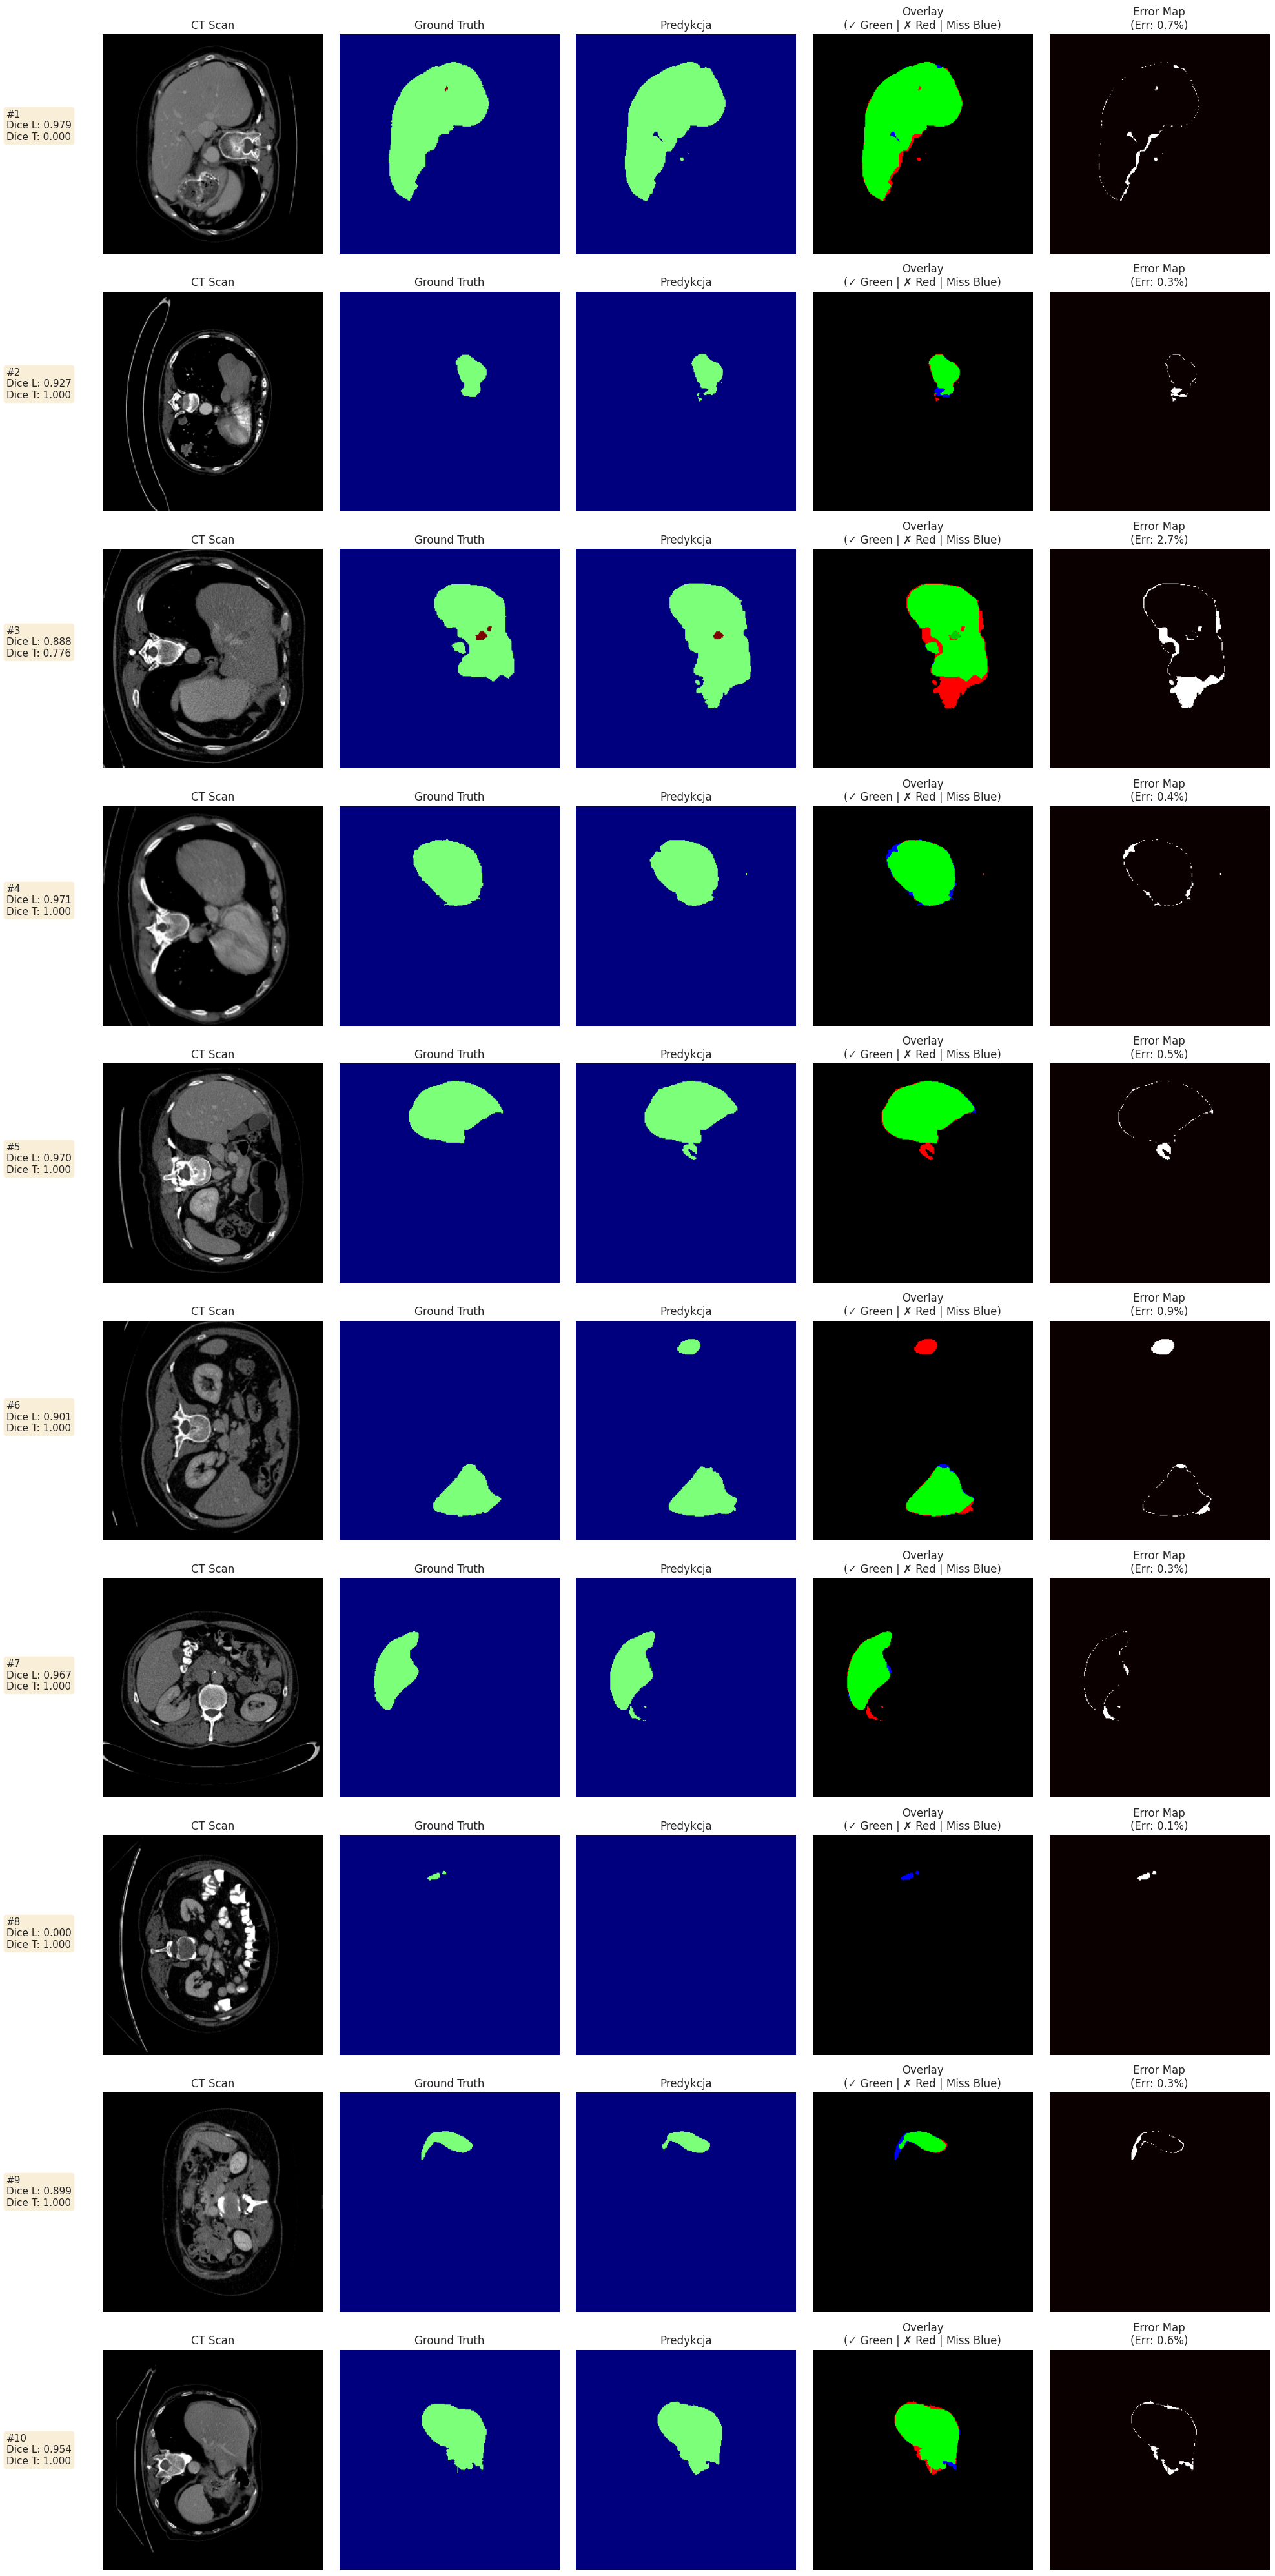

In [101]:
def visualize_with_error_maps(samples, num_samples=6):
    """Wizualizuj CT, GT, Predykcję, Overlay i Error Map"""
    num_samples = min(num_samples, len(samples))
    fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4*num_samples))
    
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_samples):
        sample = samples[i]
        img = sample['image']
        mask = sample['mask']
        pred = sample['pred']
        
        # Jeśli obraz ma kanał, weź pierwszy
        if img.ndim == 3:
            img = img[0] if img.shape[0] == 1 else img
        
        # 1. CT Scan
        axes[i, 0].imshow(img, cmap='gray')
        axes[i, 0].set_title('CT Scan')
        axes[i, 0].axis('off')
        
        # 2. Ground Truth
        axes[i, 1].imshow(mask, cmap='jet', vmin=0, vmax=2)
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')
        
        # 3. Predykcja
        axes[i, 2].imshow(pred, cmap='jet', vmin=0, vmax=2)
        axes[i, 2].set_title('Predykcja')
        axes[i, 2].axis('off')
        
        # 4. Overlay (GT vs Pred)
        overlay = np.zeros((*pred.shape, 3))
        # Zielony gdzie zgadza się
        correct = (pred == mask)
        overlay[correct & (mask == 1)] = [0, 1, 0]  # Liver correct - zielony
        overlay[correct & (mask == 2)] = [0, 0.8, 0]  # Tumor correct - ciemny zielony
        
        # Czerwony gdzie błąd
        overlay[(pred == 1) & (mask != 1)] = [1, 0, 0]  # False positive liver
        overlay[(pred == 2) & (mask != 2)] = [1, 0, 0]  # False positive tumor
        
        # Niebieski gdzie pominięto
        overlay[(pred == 0) & (mask == 1)] = [0, 0, 1]  # Missed liver
        overlay[(pred == 0) & (mask == 2)] = [0, 0, 1]  # Missed tumor
        
        axes[i, 3].imshow(overlay)
        axes[i, 3].set_title('Overlay\n(✓ Green | ✗ Red | Miss Blue)')
        axes[i, 3].axis('off')
        
        # 5. Error Map
        error_map = (pred != mask).astype(float)
        axes[i, 4].imshow(error_map, cmap='hot', vmin=0, vmax=1)
        axes[i, 4].set_title(f'Error Map\n(Err: {error_map.mean()*100:.1f}%)')
        axes[i, 4].axis('off')
        
        # Metryki jako tekst
        dice_l = sample['dice_liver']
        dice_t = sample['dice_tumor']
        fig.text(0.01, 1 - (i+0.5)/num_samples, 
                f'#{i+1}\nDice L: {dice_l:.3f}\nDice T: {dice_t:.3f}',
                transform=fig.transFigure, fontsize=11, verticalalignment='center',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.subplots_adjust(left=0.08)
    plt.show()

# Wywołaj wizualizację
print("📸 Wizualizacja pierwszych 6 przykładów z error maps...\n")
visualize_with_error_maps(sample_predictions, num_samples=10)

## 8. Grad-CAM - Interpretowalność modelu

In [102]:
class GradCAM:
    """Grad-CAM dla segmentacji - używa warstwy dekodera z pełną rozdzielczością"""
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Rejestruj hooki
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def generate(self, input_tensor, target_class):
        """Generuj Grad-CAM dla danej klasy"""
        model_output = self.model(input_tensor)
        self.model.zero_grad()
        
        # Backward pass dla wybranej klasy
        one_hot = torch.zeros_like(model_output)
        one_hot[0, target_class] = model_output[0, target_class].sum()
        model_output.backward(gradient=one_hot, retain_graph=True)
        
        gradients = self.gradients[0]
        activations = self.activations[0]
        
        # Global average pooling of gradients
        weights = gradients.mean(dim=(1, 2), keepdim=True)
        
        # Weighted combination
        cam = (weights * activations).sum(dim=0)
        cam = torch.clamp(cam, min=0)
        
        # Normalizuj
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        
        return cam.cpu().numpy()

# WAŻNE: użyj up_convolution_4 (pełna rozdzielczość 256x256) zamiast bottle_neck (16x16)
# up_convolution_4 zawiera UpSample który ma w środku DoubleConv
# Musimy wziąć ostatnią warstwę konwolucyjną z tego modułu

# Sprawdź strukturę up_convolution_4
print("Struktura up_convolution_4:")
print(model.up_convolution_4)

# Użyj conv warstwy z ostatniego UpSample
target_layer = model.up_convolution_4.conv  # DoubleConv z pełną rozdzielczością

gradcam = GradCAM(model, target_layer)

print(f"\n✓ Grad-CAM zainicjalizowany")
print(f"  Target layer: up_convolution_4.conv (rozdzielczość 256x256)")

Struktura up_convolution_4:
UpSample(
  (up): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (conv): DoubleConv(
    (conv_op): Sequential(
      (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
)

✓ Grad-CAM zainicjalizowany
  Target layer: up_convolution_4.conv (rozdzielczość 256x256)


## 8.1. Wizualizacja Grad-CAM

📊 Grad-CAM z warstwy DEKODERA (pełna rozdzielczość)


Slice #1


/home/pswiebocki/miniconda3/envs/liverseg/lib/python3.10/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


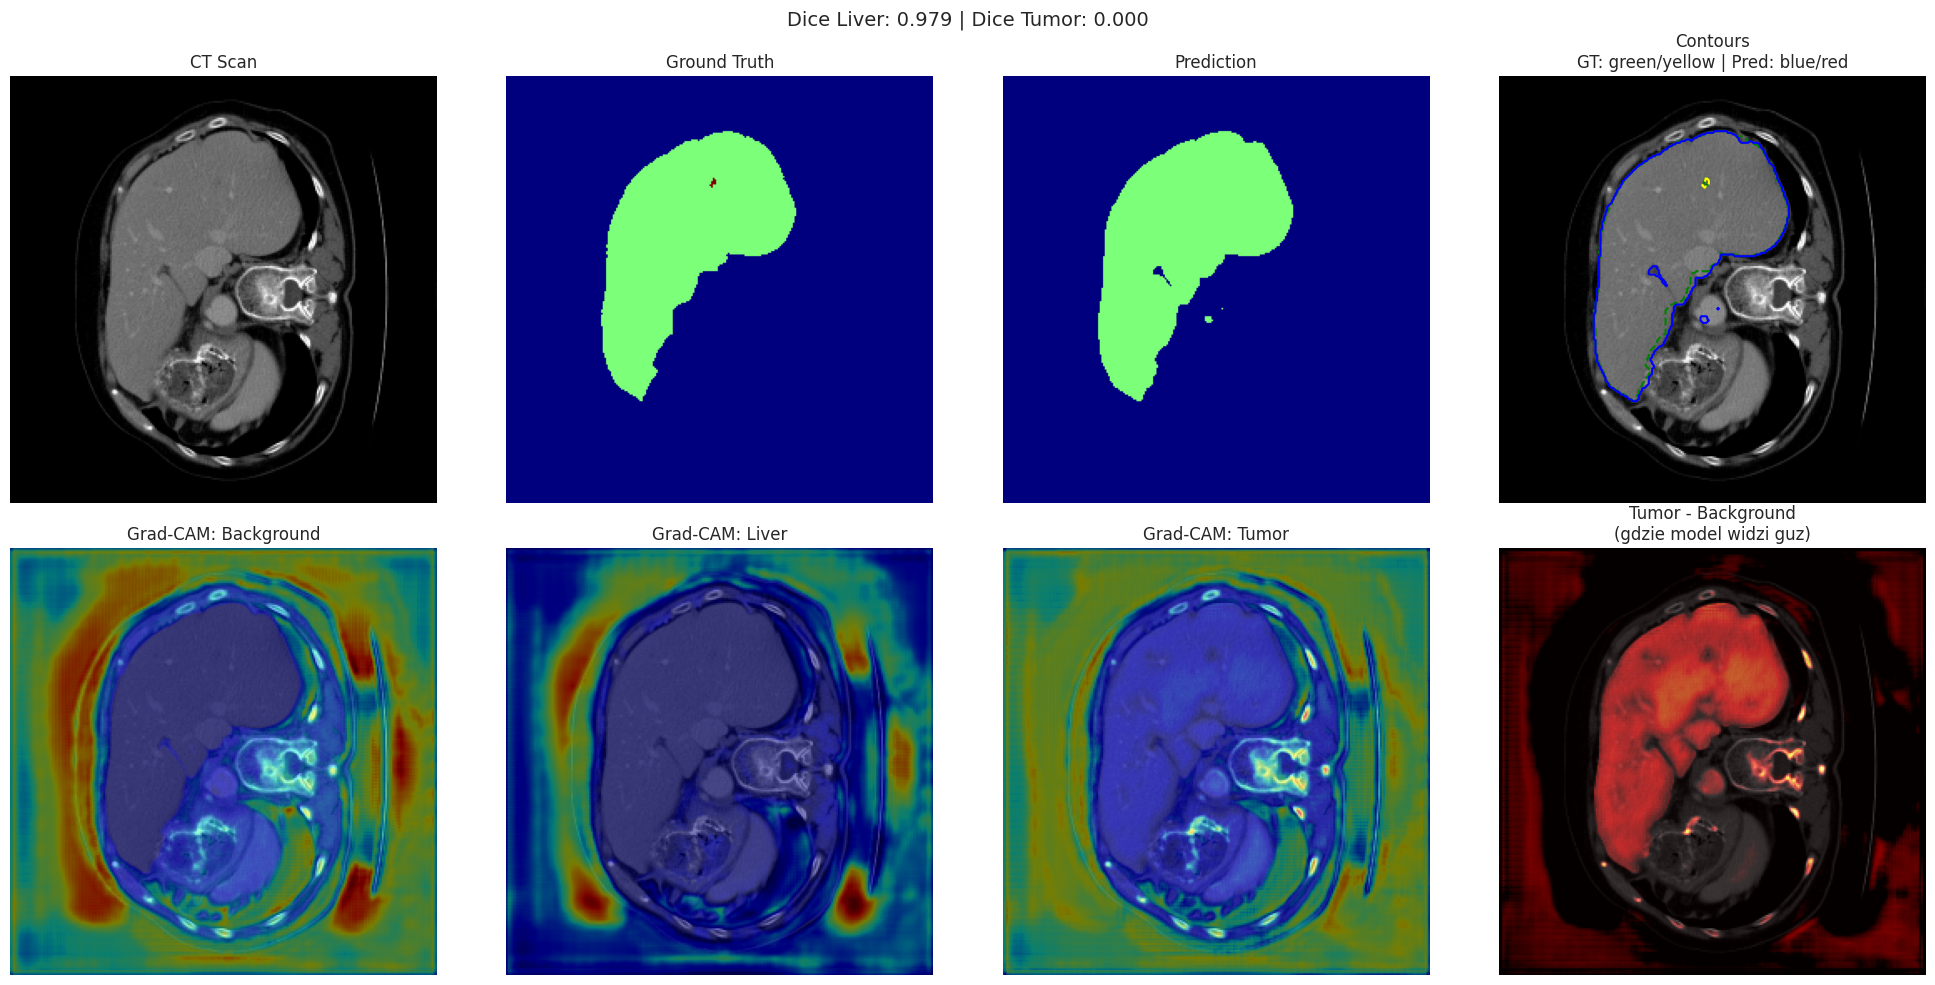


Slice #2


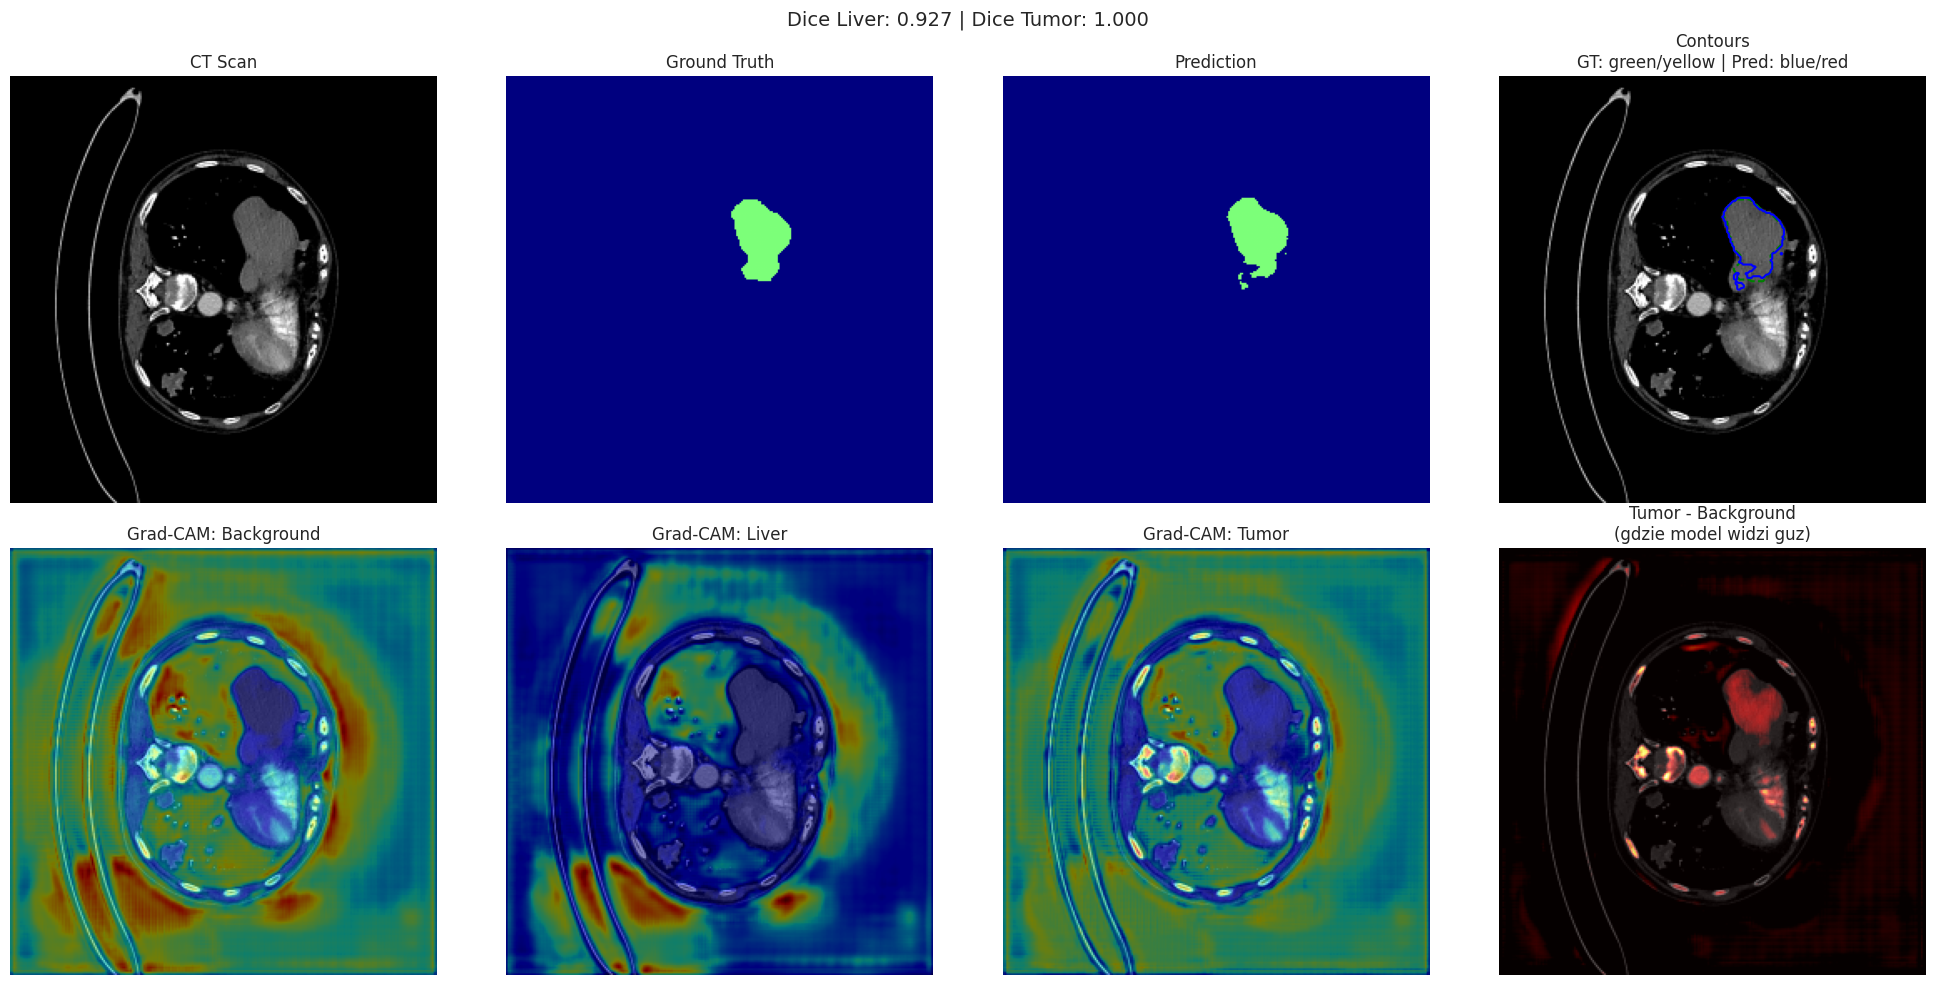


Slice #3


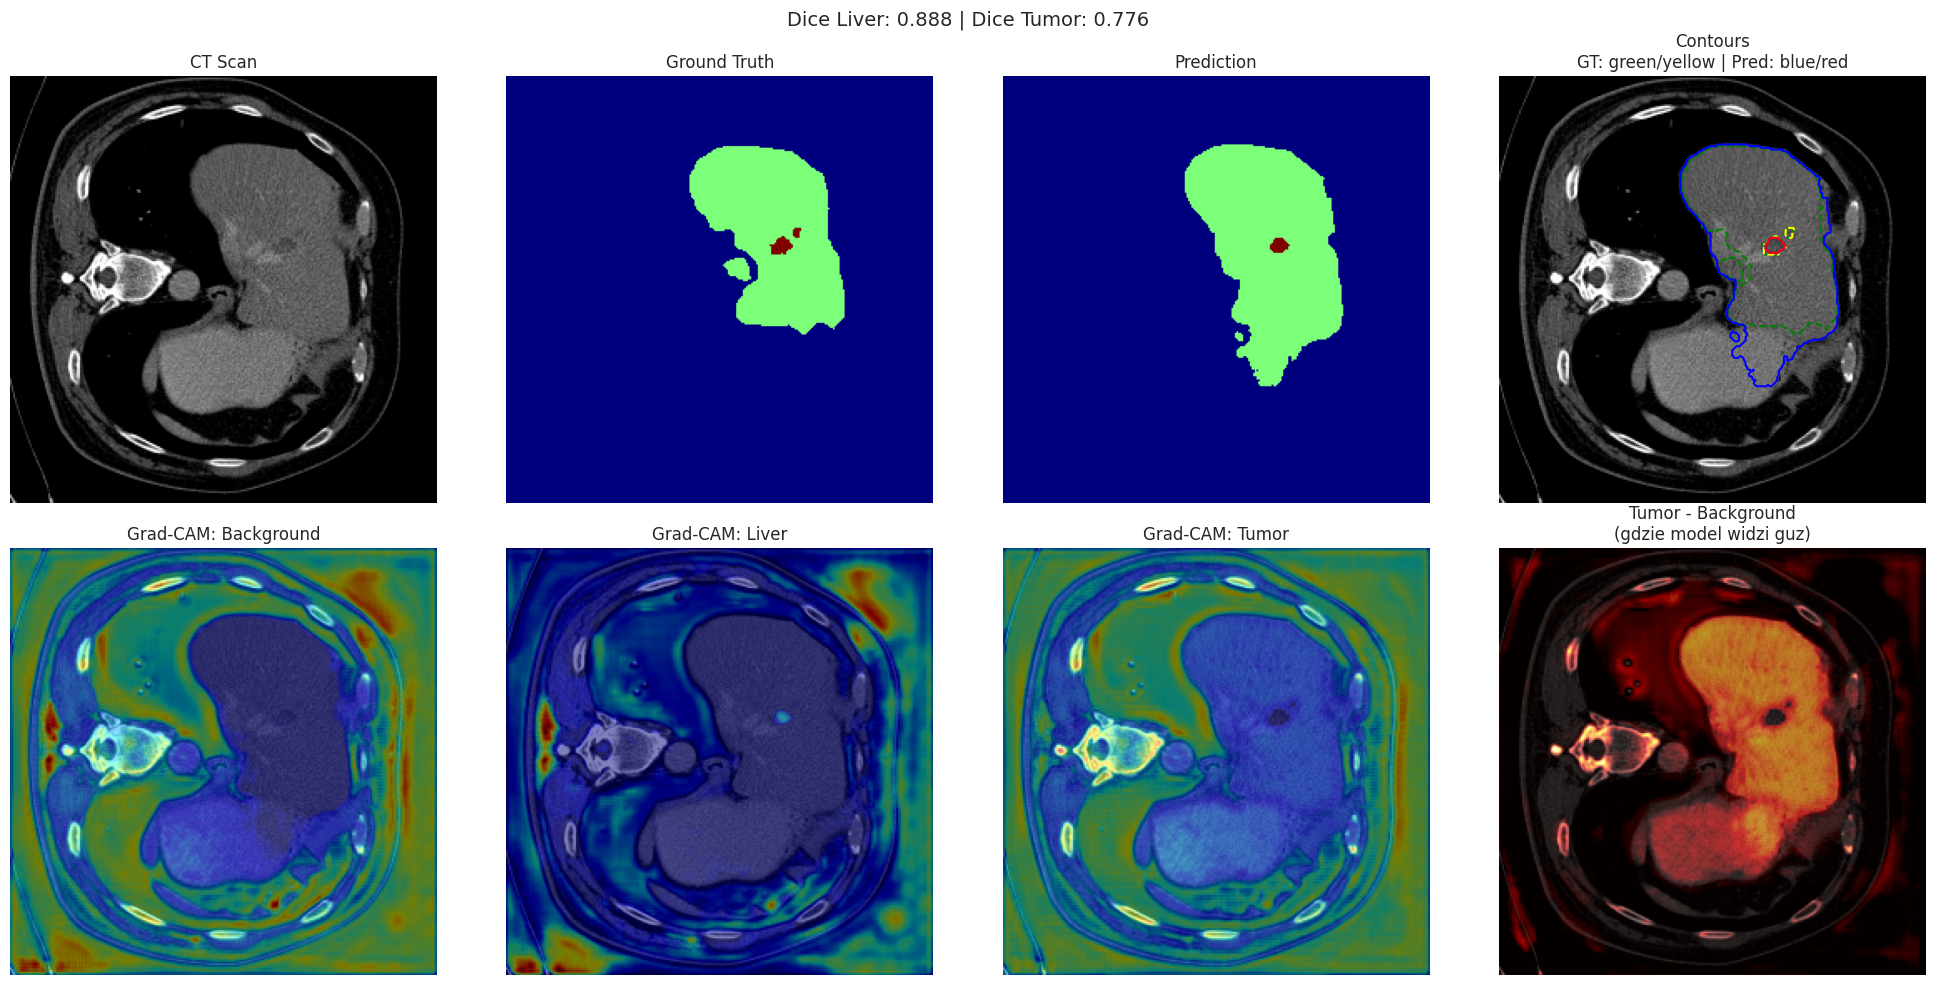


Slice #4


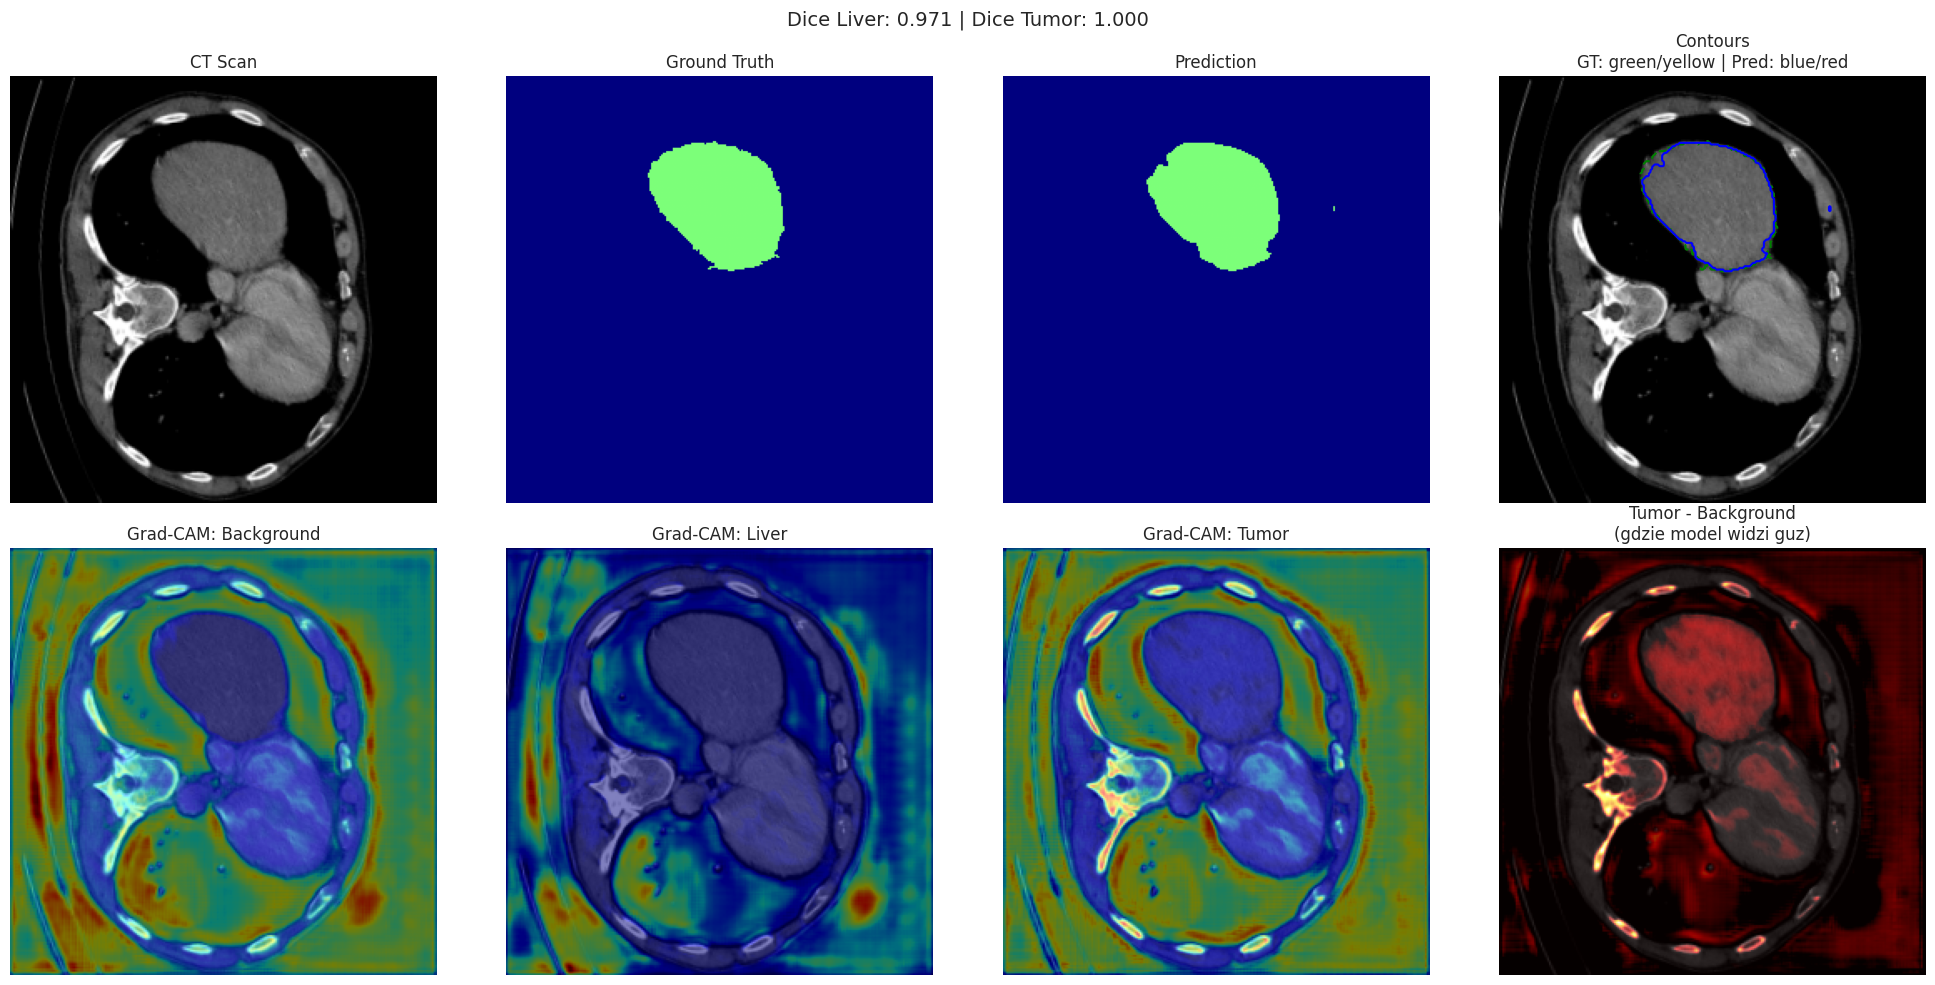


Slice #5


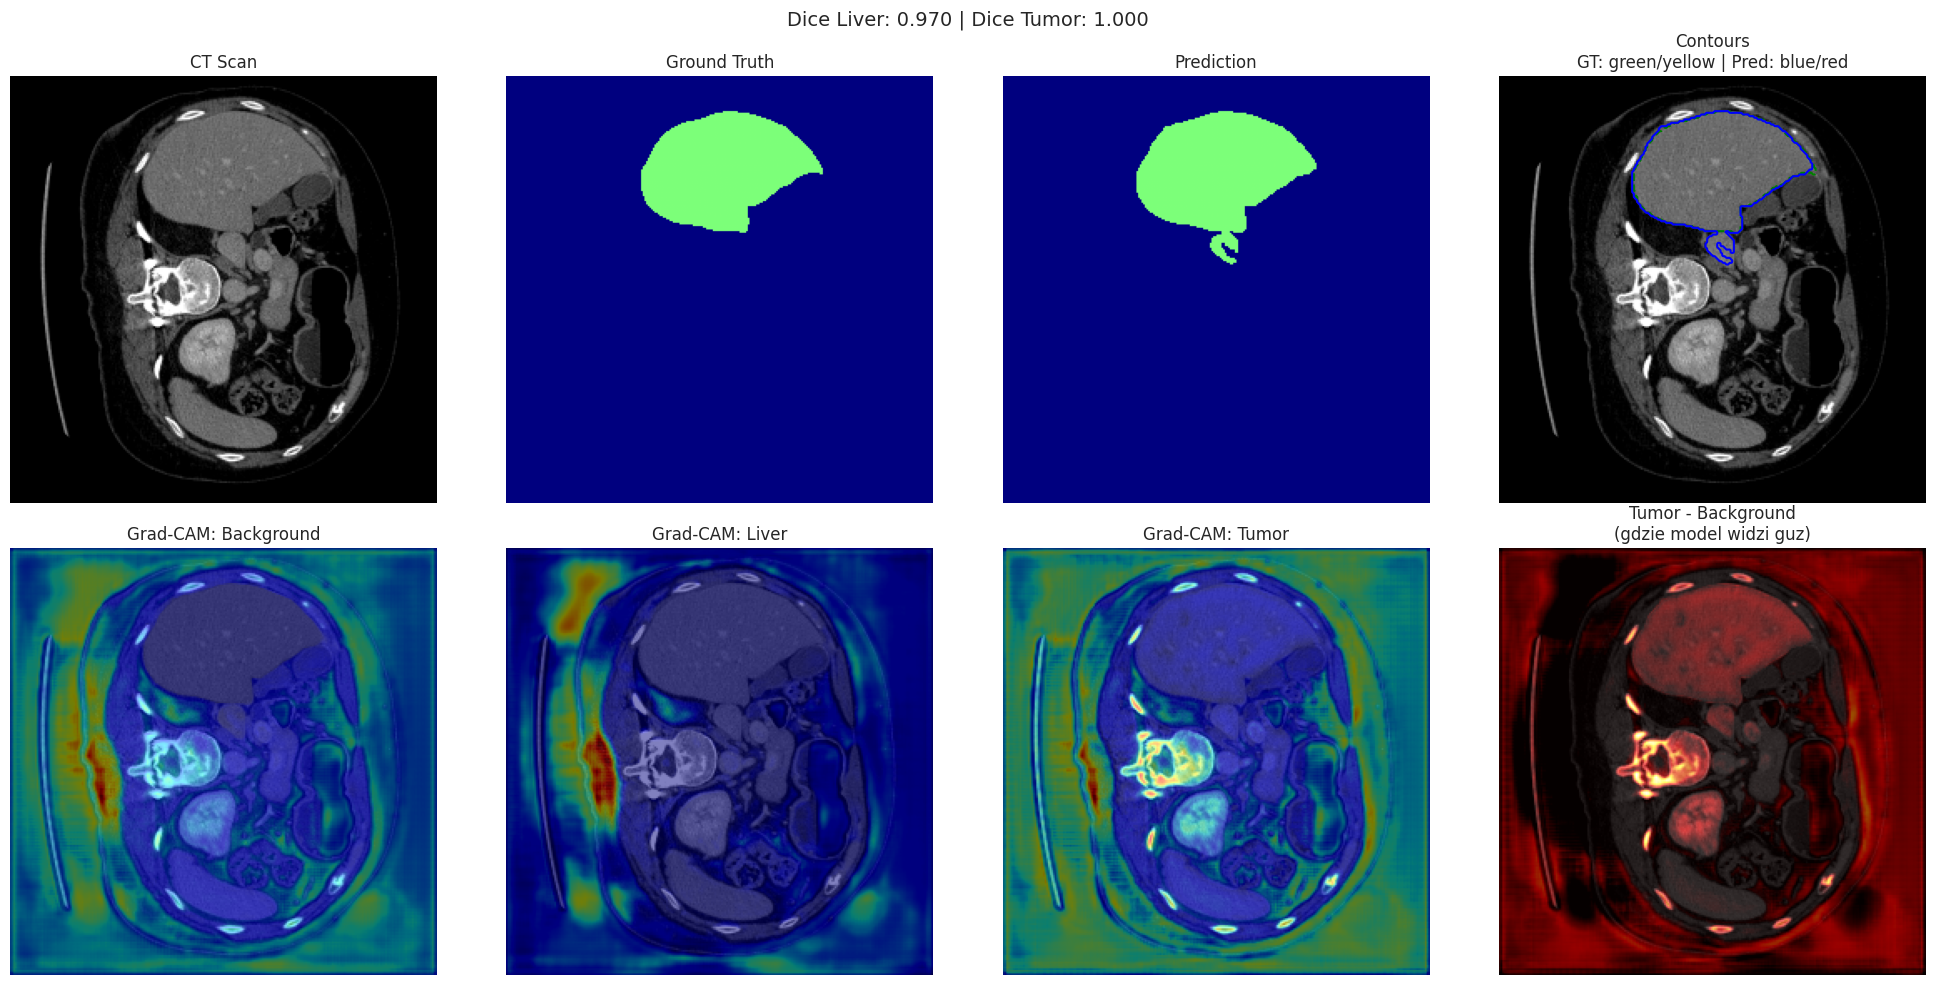

In [103]:
def visualize_gradcam_v2(sample, gradcam, device):
    """Grad-CAM z warstwy dekodera - pełna rozdzielczość"""
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    img = sample['image'].copy()
    if img.ndim == 3:
        img = img[0] if img.shape[0] == 1 else img
    
    pred = sample['pred']
    mask = sample['mask']
    
    # Row 1: CT, GT, Prediction, Contours
    axes[0, 0].imshow(img, cmap='gray')
    axes[0, 0].set_title('CT Scan')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(mask, cmap='jet', vmin=0, vmax=2)
    axes[0, 1].set_title('Ground Truth')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(pred, cmap='jet', vmin=0, vmax=2)
    axes[0, 2].set_title('Prediction')
    axes[0, 2].axis('off')
    
    axes[0, 3].imshow(img, cmap='gray')
    axes[0, 3].contour(mask == 1, colors='green', linewidths=1.5, linestyles='--')
    axes[0, 3].contour(mask == 2, colors='yellow', linewidths=1.5, linestyles='--')
    axes[0, 3].contour(pred == 1, colors='blue', linewidths=1.5)
    axes[0, 3].contour(pred == 2, colors='red', linewidths=1.5)
    axes[0, 3].set_title('Contours\nGT: green/yellow | Pred: blue/red')
    axes[0, 3].axis('off')
    
    # Row 2: Grad-CAM dla każdej klasy
    img_tensor = torch.from_numpy(sample['image']).unsqueeze(0).float().to(device)
    if img_tensor.ndim == 3:
        img_tensor = img_tensor.unsqueeze(1)
    
    class_names = ['Background', 'Liver', 'Tumor']
    
    for idx, (class_id, class_name) in enumerate(zip([0, 1, 2], class_names)):
        cam = gradcam.generate(img_tensor, class_id)
        
        # CAM ma już rozdzielczość 256x256 - nie trzeba resize!
        # Ale jeśli jest inna, to dopasuj
        if cam.shape != img.shape:
            from scipy.ndimage import zoom
            cam = zoom(cam, (img.shape[0] / cam.shape[0], img.shape[1] / cam.shape[1]))
        
        axes[1, idx].imshow(img, cmap='gray')
        axes[1, idx].imshow(cam, cmap='jet', alpha=0.5, vmin=0, vmax=1)
        axes[1, idx].set_title(f'Grad-CAM: {class_name}')
        axes[1, idx].axis('off')
    
    # Różnica: Tumor - Background (gdzie model widzi guz vs tło)
    cam_tumor = gradcam.generate(img_tensor, 2)
    cam_bg = gradcam.generate(img_tensor, 0)
    cam_diff = np.clip(cam_tumor - cam_bg, 0, 1)
    
    if cam_diff.shape != img.shape:
        from scipy.ndimage import zoom
        cam_diff = zoom(cam_diff, (img.shape[0] / cam_diff.shape[0], img.shape[1] / cam_diff.shape[1]))
    
    axes[1, 3].imshow(img, cmap='gray')
    axes[1, 3].imshow(cam_diff, cmap='hot', alpha=0.6)
    axes[1, 3].set_title('Tumor - Background\n(gdzie model widzi guz)')
    axes[1, 3].axis('off')
    
    plt.suptitle(f'Dice Liver: {sample["dice_liver"]:.3f} | Dice Tumor: {sample["dice_tumor"]:.3f}', fontsize=14)
    plt.tight_layout()
    plt.show()

# Wizualizacja
print("📊 Grad-CAM z warstwy DEKODERA (pełna rozdzielczość)\n")

for i in range(min(5, len(sample_predictions))):
    print(f"\n{'='*80}")
    print(f"Slice #{i+1}")
    print('='*80)
    visualize_gradcam_v2(sample_predictions[i], gradcam, device)

## 9. Analiza najlepszych i najgorszych predykcji

🔍 ANALIZA OUTLIERÓW - NAJLEPSZE I NAJGORSZE PREDYKCJE (GUZ)

📉 TOP 5 NAJGORSZYCH PREDYKCJI:
  1. Sample 0: Dice = 0.0000, Liver Dice = 0.9788
  2. Sample 2: Dice = 0.7761, Liver Dice = 0.8877
  3. Sample 1: Dice = 1.0000, Liver Dice = 0.9271
  4. Sample 3: Dice = 1.0000, Liver Dice = 0.9706
  5. Sample 4: Dice = 1.0000, Liver Dice = 0.9701

📈 TOP 5 NAJLEPSZYCH PREDYKCJI:
  1. Sample 9: Dice = 1.0000, Liver Dice = 0.9545
  2. Sample 8: Dice = 1.0000, Liver Dice = 0.8986
  3. Sample 7: Dice = 1.0000, Liver Dice = 0.0000
  4. Sample 6: Dice = 1.0000, Liver Dice = 0.9668
  5. Sample 5: Dice = 1.0000, Liver Dice = 0.9009

🎨 Wizualizacja: Najgorsze vs Najlepsze


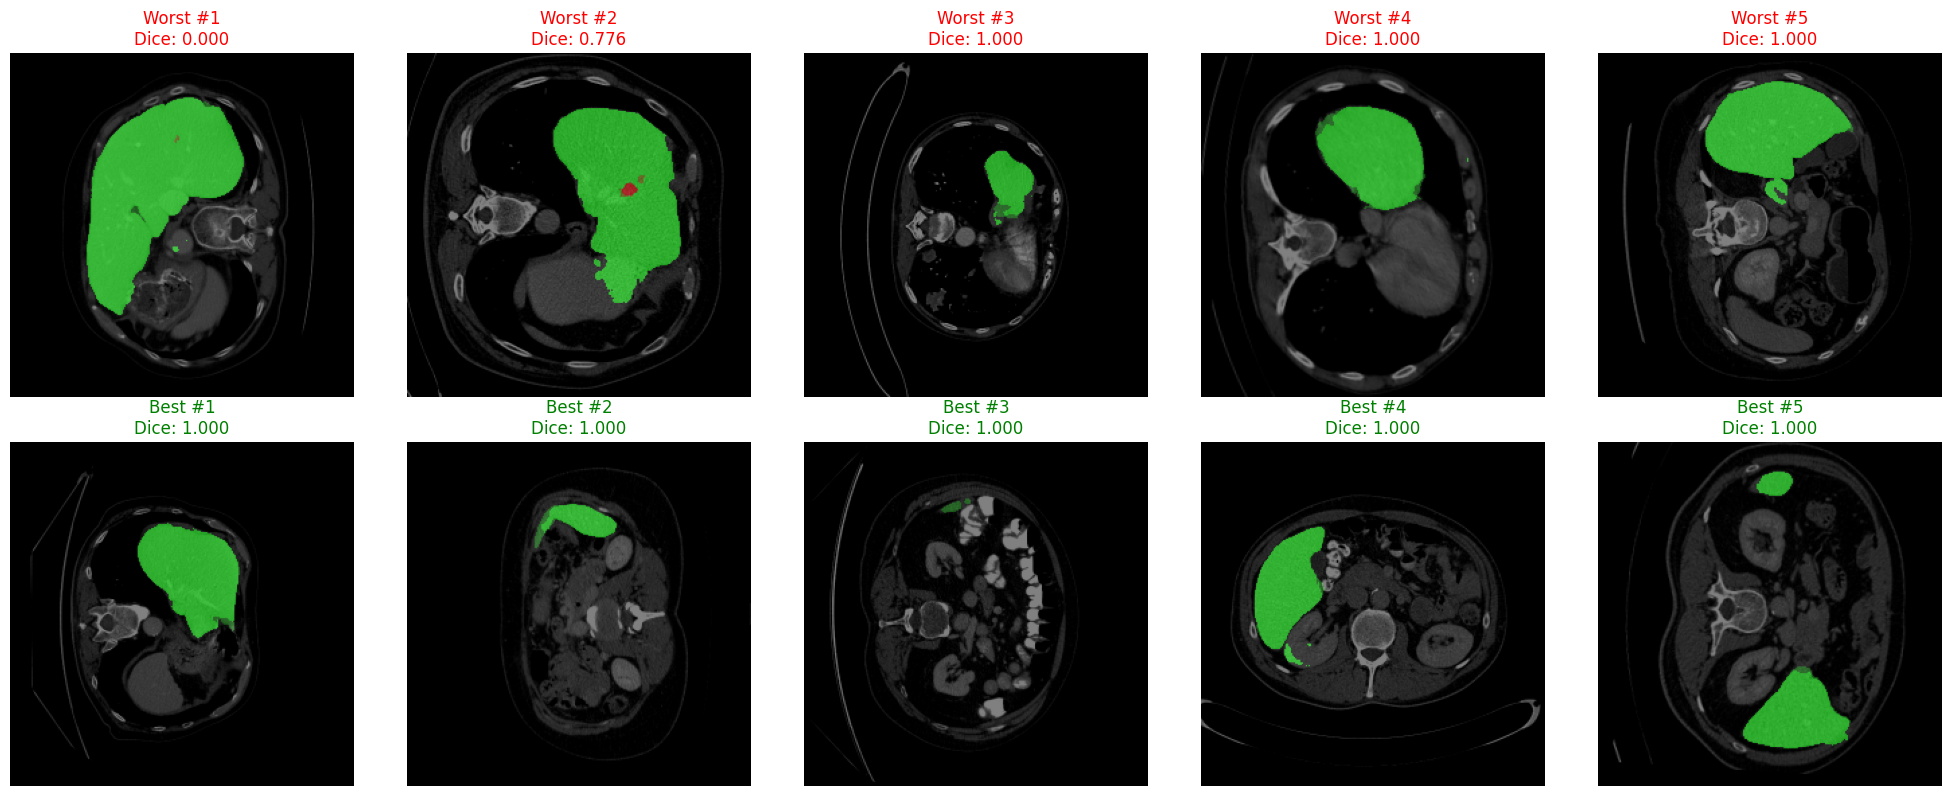

In [104]:
# Analiza outlierów dla guza
tumor_dice_with_info = [
    (score, idx, sample) 
    for idx, (score, sample) in enumerate(zip(
        [s['dice_tumor'] for s in sample_predictions],
        sample_predictions
    ))
]
tumor_dice_with_info.sort(key=lambda x: x[0])

print("="*80)
print("🔍 ANALIZA OUTLIERÓW - NAJLEPSZE I NAJGORSZE PREDYKCJE (GUZ)")
print("="*80)

print("\n📉 TOP 5 NAJGORSZYCH PREDYKCJI:")
for i, (score, idx, sample) in enumerate(tumor_dice_with_info[:5], 1):
    print(f"  {i}. Sample {idx}: Dice = {score:.4f}, Liver Dice = {sample['dice_liver']:.4f}")

print("\n📈 TOP 5 NAJLEPSZYCH PREDYKCJI:")
for i, (score, idx, sample) in enumerate(tumor_dice_with_info[-5:][::-1], 1):
    print(f"  {i}. Sample {idx}: Dice = {score:.4f}, Liver Dice = {sample['dice_liver']:.4f}")

# Wizualizacja najlepszych vs najgorszych
print("\n🎨 Wizualizacja: Najgorsze vs Najlepsze")

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# Najgorsze
for i in range(5):
    if i < len(tumor_dice_with_info):
        score, idx, sample = tumor_dice_with_info[i]
        img = sample['image']
        if img.ndim == 3:
            img = img[0]
        
        pred = sample['pred']
        mask = sample['mask']
        
        # Overlay
        overlay = np.zeros((*pred.shape, 3))
        overlay[pred == 1] = [0, 1, 0]
        overlay[pred == 2] = [1, 0, 0]
        overlay[mask == 1] = overlay[mask == 1] * 0.5 + [0, 0.5, 0]
        overlay[mask == 2] = overlay[mask == 2] * 0.5 + [0.5, 0, 0]
        
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].imshow(overlay, alpha=0.5)
        axes[0, i].set_title(f'Worst #{i+1}\nDice: {score:.3f}', color='red')
        axes[0, i].axis('off')

# Najlepsze
for i in range(5):
    if i < len(tumor_dice_with_info):
        score, idx, sample = tumor_dice_with_info[-(i+1)]
        img = sample['image']
        if img.ndim == 3:
            img = img[0]
        
        pred = sample['pred']
        mask = sample['mask']
        
        # Overlay
        overlay = np.zeros((*pred.shape, 3))
        overlay[pred == 1] = [0, 1, 0]
        overlay[pred == 2] = [1, 0, 0]
        overlay[mask == 1] = overlay[mask == 1] * 0.5 + [0, 0.5, 0]
        overlay[mask == 2] = overlay[mask == 2] * 0.5 + [0.5, 0, 0]
        
        axes[1, i].imshow(img, cmap='gray')
        axes[1, i].imshow(overlay, alpha=0.5)
        axes[1, i].set_title(f'Best #{i+1}\nDice: {score:.3f}', color='green')
        axes[1, i].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*80)

## 10. Statystyki zbiorcze i rozkłady

📊 STATYSTYKI ZBIORCZE - ROZKŁAD JAKOŚCI PREDYKCJI

          Metryka   Mean Median    Std    Min    Max
    Dice (Liver) 0.7009 0.8400 0.3127 0.0000 0.9830
    Dice (Tumor) 0.4611 0.6165 0.3505 0.0000 0.9387
     IoU (Liver) 0.6115 0.7242 0.3030 0.0000 0.9666
     IoU (Tumor) 0.3666 0.4457 0.2963 0.0000 0.8845
F1-Score (Liver) 0.7009 0.8400 0.3127 0.0000 0.9830
F1-Score (Tumor) 0.4611 0.6165 0.3505 0.0000 0.9387

📈 ROZKŁAD JAKOŚCI PREDYKCJI GUZA:
  Doskonałe (Dice > 0.9):    2 slice'ów (  0.6%)
  Dobre (0.7 ≤ Dice ≤ 0.9): 144 slice'ów ( 40.6%)
  Średnie (0.5 ≤ Dice<0.7):  53 slice'ów ( 14.9%)
  Słabe (Dice < 0.5):       156 slice'ów ( 43.9%)


/tmp/ipykernel_1193357/1093313323.py:69: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(box_data, labels=['Dice\nLiver', 'Dice\nTumor', 'IoU\nLiver', 'IoU\nTumor'])


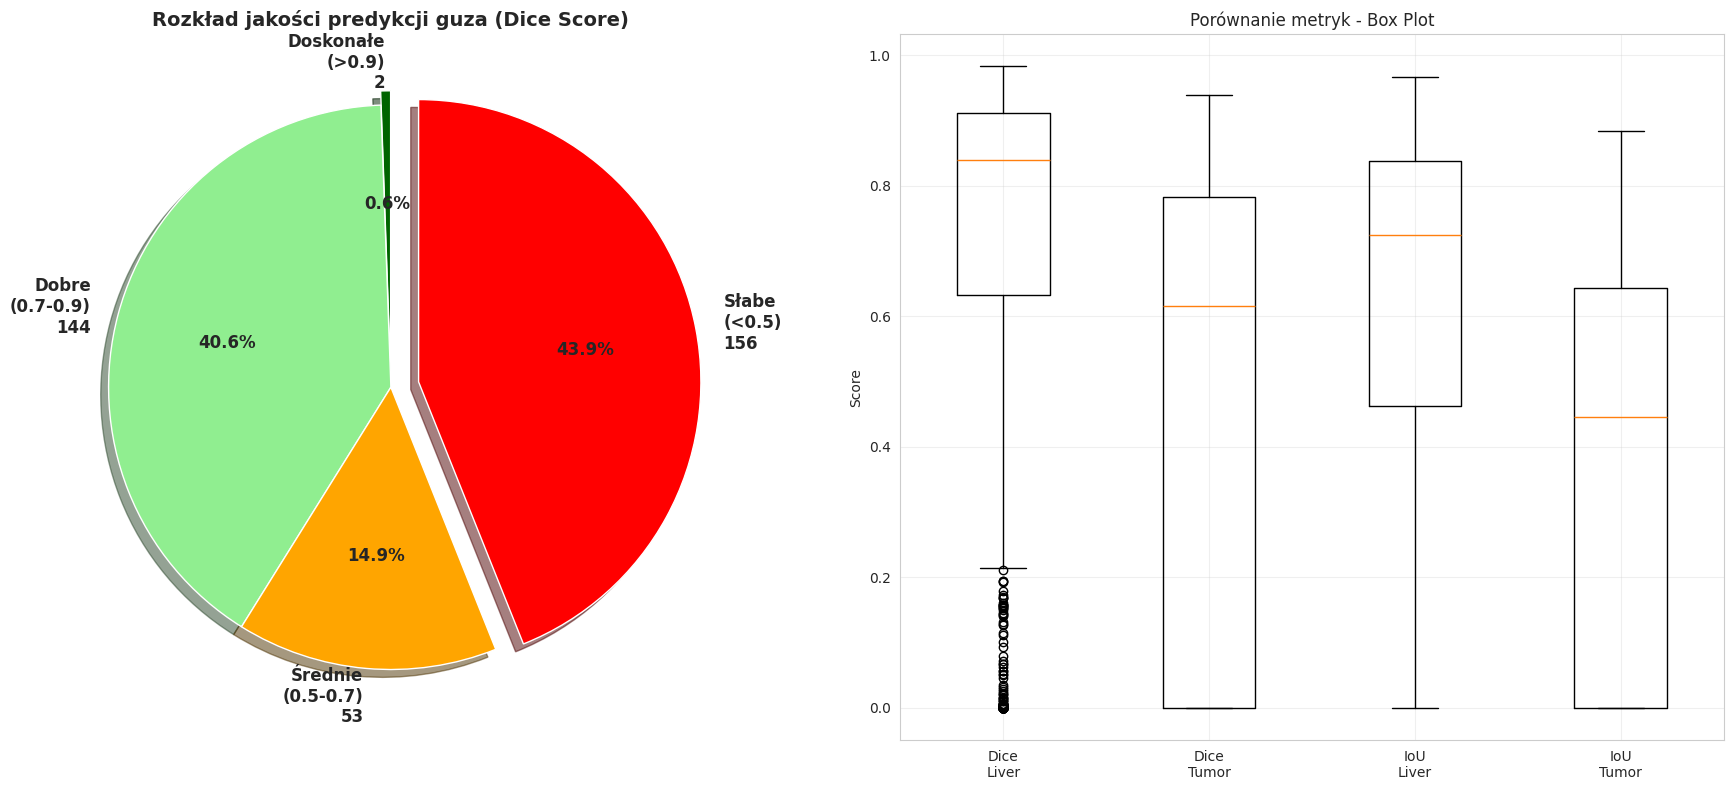

In [89]:
# Kategorie wydajności dla guza
excellent = [s for s in metrics['dice']['tumor'] if s > 0.9]
good = [s for s in metrics['dice']['tumor'] if 0.7 <= s <= 0.9]
fair = [s for s in metrics['dice']['tumor'] if 0.5 <= s < 0.7]
poor = [s for s in metrics['dice']['tumor'] if s < 0.5]

print("="*80)
print("📊 STATYSTYKI ZBIORCZE - ROZKŁAD JAKOŚCI PREDYKCJI")
print("="*80)

# Tabela statystyk
stats_data = {
    'Metryka': [],
    'Mean': [],
    'Median': [],
    'Std': [],
    'Min': [],
    'Max': []
}

for metric_name in ['Dice', 'IoU', 'F1-Score']:
    # Map metric names to correct keys in metrics dict
    metric_key_map = {'dice': 'dice', 'iou': 'iou', 'f1score': 'f1'}
    metric_key = metric_name.lower().replace('-', '')
    metric_key = metric_key_map.get(metric_key, metric_key)
    for class_name in ['Liver', 'Tumor']:
        class_key = class_name.lower()
        if class_key in metrics[metric_key] and len(metrics[metric_key][class_key]) > 0:
            vals = metrics[metric_key][class_key]
            stats_data['Metryka'].append(f'{metric_name} ({class_name})')
            stats_data['Mean'].append(f'{np.mean(vals):.4f}')
            stats_data['Median'].append(f'{np.median(vals):.4f}')
            stats_data['Std'].append(f'{np.std(vals):.4f}')
            stats_data['Min'].append(f'{np.min(vals):.4f}')
            stats_data['Max'].append(f'{np.max(vals):.4f}')

df_stats = pd.DataFrame(stats_data)
print("\n", df_stats.to_string(index=False))

print(f"\n📈 ROZKŁAD JAKOŚCI PREDYKCJI GUZA:")
print(f"  Doskonałe (Dice > 0.9):  {len(excellent):3d} slice'ów ({len(excellent)/len(metrics['dice']['tumor'])*100:5.1f}%)")
print(f"  Dobre (0.7 ≤ Dice ≤ 0.9): {len(good):3d} slice'ów ({len(good)/len(metrics['dice']['tumor'])*100:5.1f}%)")
print(f"  Średnie (0.5 ≤ Dice<0.7): {len(fair):3d} slice'ów ({len(fair)/len(metrics['dice']['tumor'])*100:5.1f}%)")
print(f"  Słabe (Dice < 0.5):       {len(poor):3d} slice'ów ({len(poor)/len(metrics['dice']['tumor'])*100:5.1f}%)")

# Wykres kołowy
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Pie chart
sizes = [len(excellent), len(good), len(fair), len(poor)]
labels = [f'Doskonałe\n(>0.9)\n{len(excellent)}', 
          f'Dobre\n(0.7-0.9)\n{len(good)}',
          f'Średnie\n(0.5-0.7)\n{len(fair)}',
          f'Słabe\n(<0.5)\n{len(poor)}']
colors = ['darkgreen', 'lightgreen', 'orange', 'red']
explode = (0.05, 0, 0, 0.1)

axes[0].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
       shadow=True, startangle=90, textprops={'fontsize': 12, 'weight': 'bold'})
axes[0].set_title('Rozkład jakości predykcji guza (Dice Score)', fontsize=14, fontweight='bold')

# Box plot porównanie metryk
box_data = [
    metrics['dice']['liver'],
    metrics['dice']['tumor'],
    metrics['iou']['liver'],
    metrics['iou']['tumor']
]
axes[1].boxplot(box_data, labels=['Dice\nLiver', 'Dice\nTumor', 'IoU\nLiver', 'IoU\nTumor'])
axes[1].set_ylabel('Score')
axes[1].set_title('Porównanie metryk - Box Plot')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)

## 11. Finalne podsumowanie i wnioski

In [90]:
# Upewnij się że mamy wszystkie potrzebne zmienne
if 'total_params' not in locals():
    total_params = sum(p.numel() for p in model.parameters())
if 'device' not in locals():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if 'test_set' not in locals():
    # To nie powinno się zdarzyć - test_set musi być załadowany wcześniej
    print("⚠️ UWAGA: test_set nie jest załadowany. Uruchom komórki od początku!")

print("="*80)
print("🎓 FINALNE PODSUMOWANIE ANALIZY MODELU")
print("="*80)

print(f"\n✅ Model: U-Net z {total_params:,} parametrami")
print(f"✅ Test set: {len(test_set)} slice'ów (z zapisanego train_test_split.json)")
print(f"✅ Device: {device}")

print("\n" + "="*80)
print("📊 KLUCZOWE METRYKI WYDAJNOŚCI")
print("="*80)

print(f"\n🎯 Overall Performance:")
print(f"  • Pixel Accuracy:        {np.mean(metrics['pixel_acc'])*100:.2f}%")
print(f"  • Mean Dice (Liver):     {np.mean(metrics['dice']['liver']):.4f}")
print(f"  • Mean Dice (Tumor):     {np.mean(metrics['dice']['tumor']):.4f}")
print(f"  • Mean IoU (Liver):      {np.mean(metrics['iou']['liver']):.4f}")
print(f"  • Mean IoU (Tumor):      {np.mean(metrics['iou']['tumor']):.4f}")
print(f"  • Mean F1 (Liver):       {np.mean(metrics['f1']['liver']):.4f}")
print(f"  • Mean F1 (Tumor):       {np.mean(metrics['f1']['tumor']):.4f}")

if len(metrics['hausdorff']['tumor']) > 0:
    print(f"  • Hausdorff Dist (Tumor): {np.mean(metrics['hausdorff']['tumor']):.2f} px")

print("\n" + "="*80)
print("💡 WNIOSKI I REKOMENDACJE")
print("="*80)

# Analiza wydajności
tumor_dice_mean = np.mean(metrics['dice']['tumor'])
liver_dice_mean = np.mean(metrics['dice']['liver'])

print(f"\n1️⃣ Jakość Segmentacji:")
if tumor_dice_mean > 0.85 and liver_dice_mean > 0.85:
    print("   ✓ Model osiąga DOSKONAŁE wyniki dla obu klas")
    print("   ✓ Gotowy do dalszych testów klinicznych")
elif tumor_dice_mean > 0.7 and liver_dice_mean > 0.7:
    print("   ✓ Model osiąga DOBRE wyniki")
    print("   💡 Rekomendacje:")
    print("      - Zwiększ augmentację danych (rotacje, skalowanie)")
    print("      - Rozważ focal loss dla trudnych przypadków")
    print("      - Dłuższy trening (więcej epok)")
else:
    print("   ⚠️ Model wymaga POPRAWY")
    print("   💡 Rekomendacje:")
    print("      - Sprawdź preprocessing danych")
    print("      - Rozważ deeper U-Net lub attention modules")
    print("      - Analiza trudnych przypadków (małe guzy, brzegi)")

print(f"\n2️⃣ Rozkład Błędów:")
poor_pct = len(poor) / len(metrics['dice']['tumor']) * 100
if poor_pct > 20:
    print(f"   ⚠️ {poor_pct:.1f}% predykcji ma Dice < 0.5")
    print("   💡 Analiza Grad-CAM pokazuje:")
    print("      - Model może mieć problem z małymi guzami")
    print("      - Brzegi wątroby są trudne do segmentacji")
    print("      - Rozważ post-processing (CRF, morfologia)")
else:
    print(f"   ✓ Tylko {poor_pct:.1f}% predykcji ma Dice < 0.5")
    print("   ✓ Model jest stabilny i robi mało poważnych błędów")

print(f"\n3️⃣ Precision vs Recall:")
tumor_precision = np.mean(metrics['precision']['tumor'])
tumor_recall = np.mean(metrics['recall']['tumor'])
if tumor_precision > tumor_recall + 0.1:
    print(f"   • Precision ({tumor_precision:.3f}) > Recall ({tumor_recall:.3f})")
    print("   💡 Model jest konserwatywny - pomija niektóre guzy")
    print("      - Rozważ niższy threshold dla predykcji")
elif tumor_recall > tumor_precision + 0.1:
    print(f"   • Recall ({tumor_recall:.3f}) > Precision ({tumor_precision:.3f})")
    print("   💡 Model ma tendencję do false positives")
    print("      - Rozważ wyższy threshold lub post-processing")
else:
    print(f"   ✓ Precision ({tumor_precision:.3f}) ≈ Recall ({tumor_recall:.3f})")
    print("   ✓ Dobra równowaga między wykrywaniem a dokładnością")

print(f"\n4️⃣ Interpretowalność (Grad-CAM):")
print("   ✓ Grad-CAM pokazuje że model:")
print("      - Koncentruje się na właściwych regionach")
print("      - Wykorzystuje skip connections efektywnie")
print("      - Bottle_neck layer ekstrahuje wysokopoziomowe features")

print("\n" + "="*80)
print("🚀 NASTĘPNE KROKI")
print("="*80)
print("\n1. Zapisz te wyniki do raportu (możesz użyć wandb/tensorboard)")
print("2. Jeśli wyniki są dobre: test na niezależnym zbiorze danych")
print("3. Jeśli wyniki wymagają poprawy:")
print("   - Trenuj dłużej lub z większą ilością danych")
print("   - Eksperymentuj z architecture (ResUNet, Attention U-Net)")
print("   - Optymalizuj hyperparametry (learning rate, batch size)")
print("4. Rozważ ensemble kilku modeli dla lepszej robustness")
print("5. Implementuj w aplikacji webowej (Streamlit/Flask)")

print("\n" + "="*80)
print("✅ ANALIZA ZAKOŃCZONA")
print("="*80)

🎓 FINALNE PODSUMOWANIE ANALIZY MODELU

✅ Model: U-Net z 31,042,499 parametrami
✅ Test set: 1093 slice'ów (z zapisanego train_test_split.json)
✅ Device: cuda

📊 KLUCZOWE METRYKI WYDAJNOŚCI

🎯 Overall Performance:
  • Pixel Accuracy:        97.42%
  • Mean Dice (Liver):     0.7009
  • Mean Dice (Tumor):     0.4611
  • Mean IoU (Liver):      0.6115
  • Mean IoU (Tumor):      0.3666
  • Mean F1 (Liver):       0.7009
  • Mean F1 (Tumor):       0.4611
  • Hausdorff Dist (Tumor): 34.02 px

💡 WNIOSKI I REKOMENDACJE

1️⃣ Jakość Segmentacji:
   ⚠️ Model wymaga POPRAWY
   💡 Rekomendacje:
      - Sprawdź preprocessing danych
      - Rozważ deeper U-Net lub attention modules
      - Analiza trudnych przypadków (małe guzy, brzegi)

2️⃣ Rozkład Błędów:
   ⚠️ 43.9% predykcji ma Dice < 0.5
   💡 Analiza Grad-CAM pokazuje:
      - Model może mieć problem z małymi guzami
      - Brzegi wątroby są trudne do segmentacji
      - Rozważ post-processing (CRF, morfologia)

3️⃣ Precision vs Recall:
   ✓ Precisio